# Import Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
plt.style.use("fivethirtyeight")
clolor_pel=sns.color_palette()
import warnings
warnings.filterwarnings("ignore")

# Reading Data by using pandas

In [2]:
df=pd.read_csv("/kaggle/input/pjme-hourly/PJME_hourly.csv")
df

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


# Explore Data

### Reading first 5 rows

In [3]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


### Overview of DataFrame Information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


### Checking null values

In [5]:
df.isnull().sum()

Datetime    0
PJME_MW     0
dtype: int64

### Total Number of Duplicate Entries

In [6]:
df.duplicated().sum()

0

### DataFrame Summary Statistics

In [7]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


### DataFrame with 'Datetime' as Index

In [8]:
df.set_index("Datetime",inplace=True)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


### Convert DataFrame Index to Datetime Format

In [9]:
df.index=pd.to_datetime(df.index)

### Time Series Plot of Energy Usage in MGW

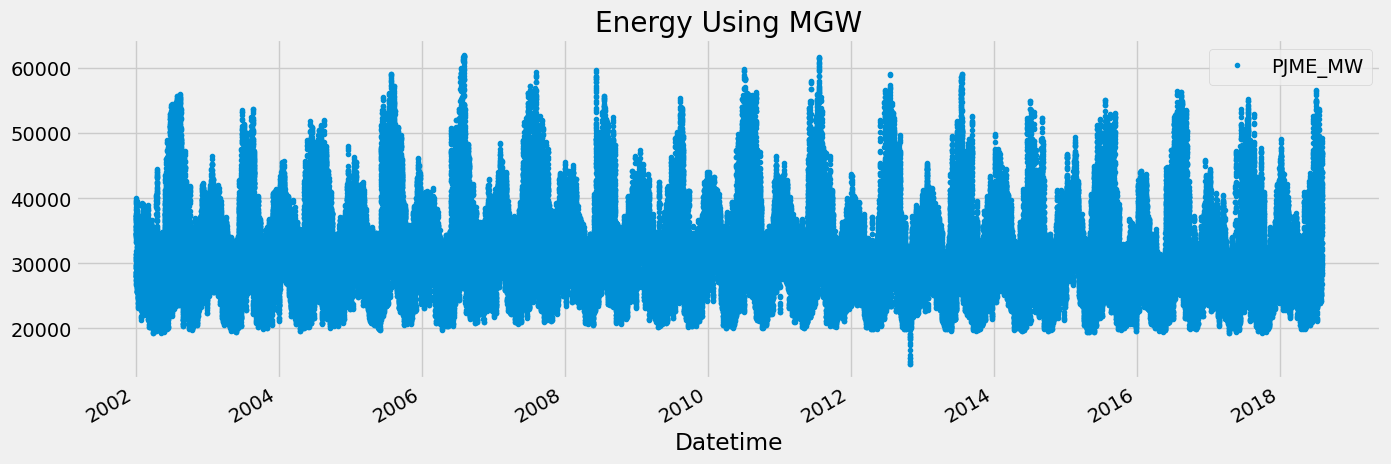

In [10]:
df.plot(figsize=(15,5),style=".",color=clolor_pel[0],title="Energy Using MGW")
plt.show()

# Feature Creating

### Feature Engineering: Time Components from Datetime Index

In [11]:
df["Hour"]=df.index.hour
df["DayOfWeek"]=df.index.dayofweek
df["Month"]=df.index.month
df["Quarter"]=df.index.quarter
df["Year"]=df.index.year
df["DayOfYear"]=df.index.dayofyear

In [12]:
df

,PJME_MW,Hour,DayOfWeek,Month,Quarter,Year,DayOfYear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,12,4,2002,365
2002-12-31 02:00:00,25147.0,2,1,12,4,2002,365
2002-12-31 03:00:00,24574.0,3,1,12,4,2002,365
2002-12-31 04:00:00,24393.0,4,1,12,4,2002,365
2002-12-31 05:00:00,24860.0,5,1,12,4,2002,365
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1


### Boxplot of Energy Usage by Hour

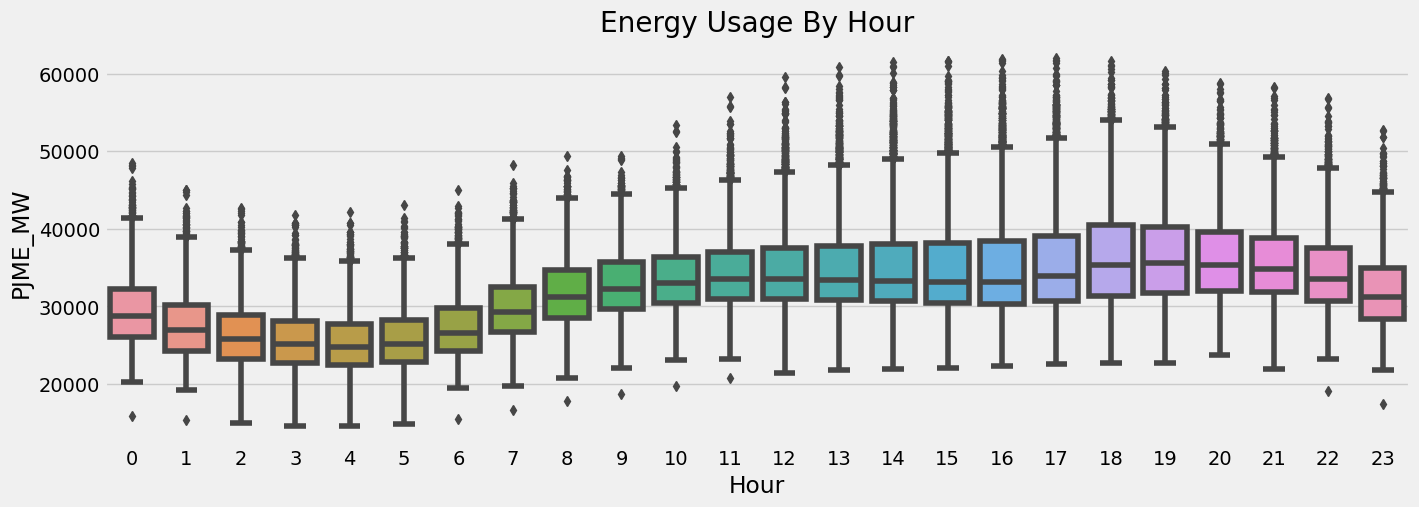

In [13]:
plt.subplots(figsize=(15,5))
sns.boxplot(data=df,x="Hour",y="PJME_MW") 
plt.title("Energy Usage By Hour")
plt.show()

### Monthly Energy Usage Distribution

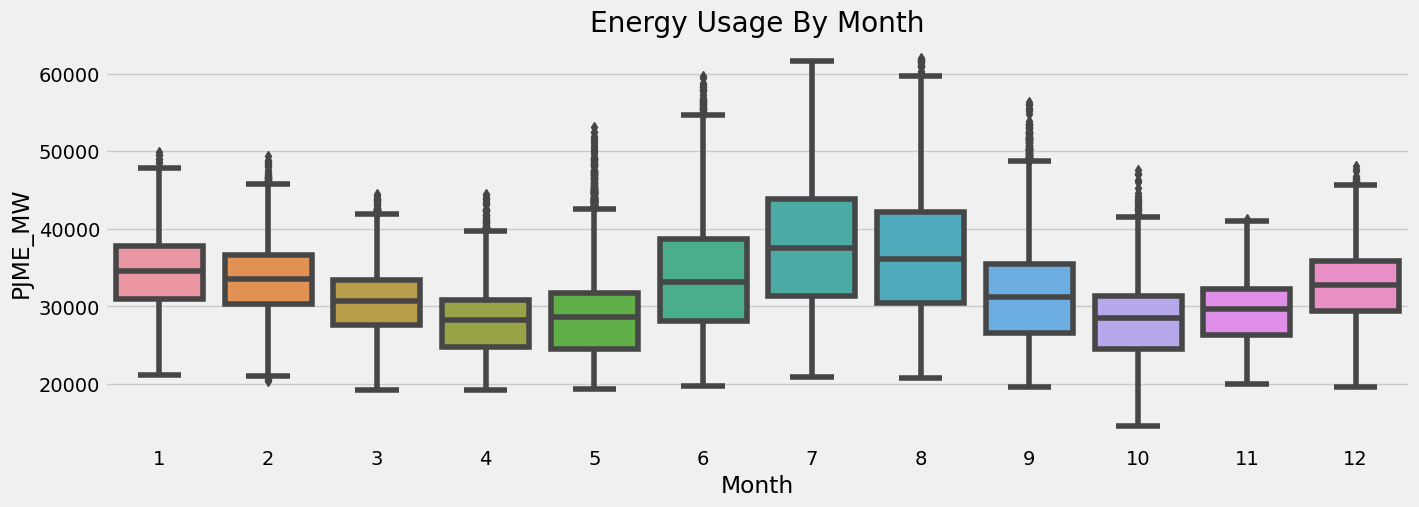

In [14]:
plt.subplots(figsize=(15,5))
sns.boxplot(data=df,x="Month",y="PJME_MW")
plt.title("Energy Usage By Month")
plt.show()

### Visualizing Energy Usage Patterns by Quarter

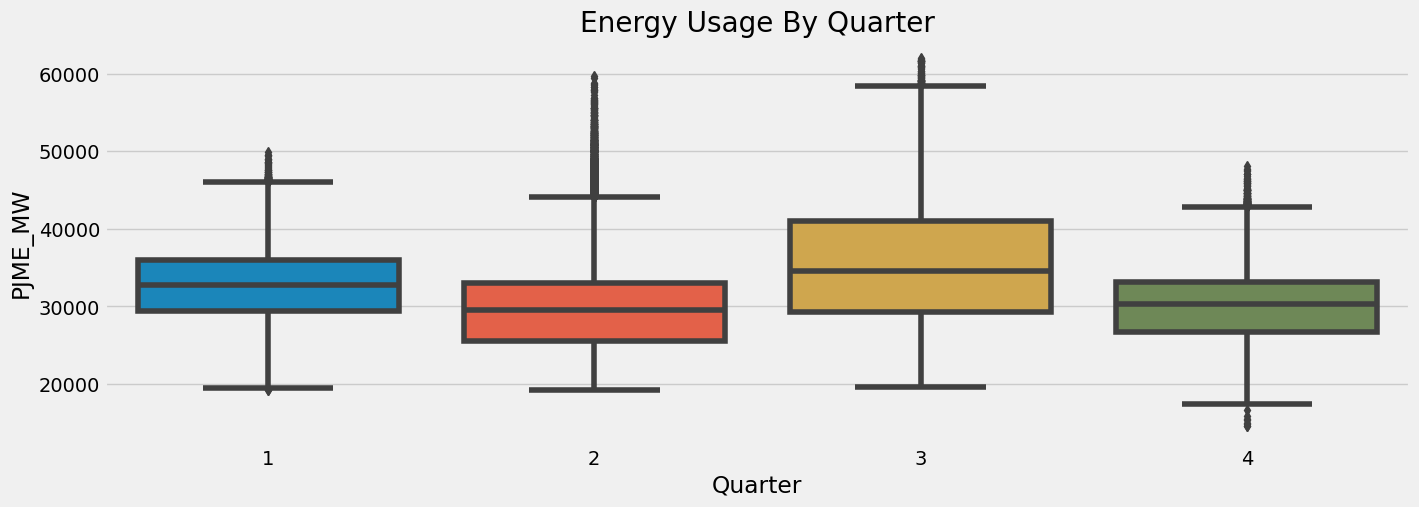

In [15]:
plt.subplots(figsize=(15,5))
sns.boxplot(data=df,x="Quarter",y="PJME_MW")
plt.title("Energy Usage By Quarter")
plt.show()

### Extract Maximum Energy Usage Record

In [40]:
max_PJME_MW=df[df["PJME_MW"]==df["PJME_MW"].max()]
max_PJME_MW

,PJME_MW,Hour,DayOfWeek,Month,Quarter,Year,DayOfYear
Datetime,,,,,,,
2006-08-02 17:00:00,62009.0,17,2,8,3,2006,214


# Bulding Model

### Splitting Data into Training and Test Sets Based on Date

In [45]:
train_set=df.loc[df.index<"01-01-2015"]
test_set=df.loc[df.index>="01-01-2015"]

### Training and Test Set Time Series Comparison with Split Indicator

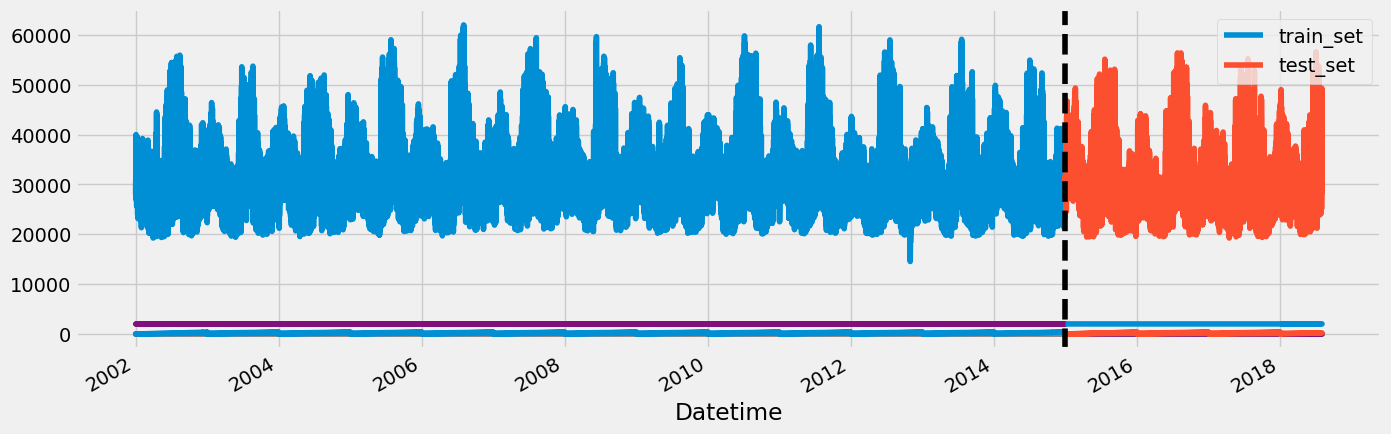

In [46]:
fig,ax=plt.subplots(figsize=(15,5))
train_set.plot(ax=ax)
test_set.plot(ax=ax)
ax.axvline("01-01-2015",color="Black",ls="--")
plt.legend(["train_set","test_set"])
plt.show()

### Separating Features and Target for Training and Test Sets

In [47]:
x_train=train_set.drop("PJME_MW",axis=1)
y_train=train_set["PJME_MW"]


x_test=test_set.drop("PJME_MW",axis=1)
y_test=test_set["PJME_MW"]

### Displaying Dimensions of Feature and Target DataFrames

In [48]:
l=[x_train,x_test,y_train,y_test]

for i in l:
    print(f"The Shape Of  is {i.shape}")
    print("******************************************************************")

The Shape Of  is (113926, 6)
******************************************************************
The Shape Of  is (31440, 6)
******************************************************************
The Shape Of  is (113926,)
******************************************************************
The Shape Of  is (31440,)
******************************************************************


### Initializing XGBoost Regressor with Parameters

In [55]:
model=XGBRegressor(n_estimator=1000,early_stopping_round=50)

### Training XGBoost Model on Training Data

In [50]:
model.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_round=50,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimator=1000,
             n_estimators=None, n_jobs=None, ...)

### Evaluating Model Performance on Training Data

In [51]:
model.score(x_train,y_train)

0.9324661462266746

### Predicting Values on Test Data Using XGBoost Model

In [52]:
pre=model.predict(x_test)

### Predicting Values on Test Data Using XGBoost Model

In [54]:
mean_squared_error(pre,y_test)

17586869.156182434